In [41]:
import pandas as pd
import numpy as np
from numpy import sqrt
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [3]:
all_files = glob.glob(r'C:\Users\sathvis\Desktop\p1_ips_data'+"/*.csv")
li = []

for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)
frame12 = pd.concat(li, axis=0, ignore_index=True)

In [28]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [4]:
frame12.device_ip.unique()

array(['10.254.228.8', '192.168.224.3', '10.254.231.7', '10.254.208.5',
       '192.168.242.6', '10.51.30.15', '10.54.34.34', '10.54.30.13',
       '172.16.92.1', '192.168.14.132', '10.157.30.11'], dtype=object)

In [22]:
sam1=frame12[frame12['device_ip']=='10.254.228.8']

In [23]:
sam1.metric_text.unique()

array(['Availability', 'Win-CPU Load', 'Mem Usage Load', 'CPU Load',
       'Swap Mem Usage'], dtype=object)

In [24]:
sam1=sam1[sam1['metric_text']=='CPU Load'][['time','metric_text','value']]
sam1.index=pd.to_datetime(sam1['time'])
sam1=sam1.drop(['time'],axis=1)

In [26]:
sam1.head()

,metric_text,value
time,,
2019-04-10 00:00:00,CPU Load,0.833333
2019-04-10 00:01:00,CPU Load,1.125000
2019-04-10 00:02:00,CPU Load,1.375000
2019-04-10 00:03:00,CPU Load,1.041667
2019-04-10 00:04:00,CPU Load,1.291667


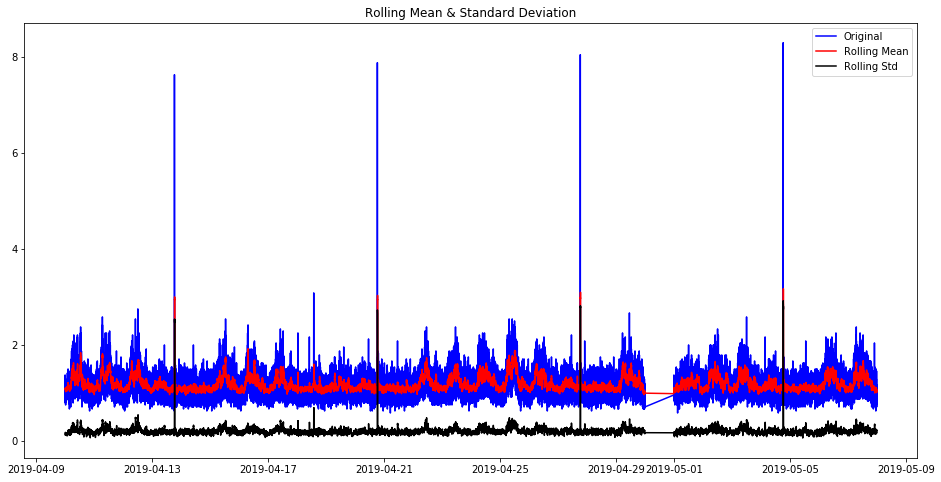

Results of Dickey-Fuller Test:
Test Statistic                -1.109845e+01
p-value                        3.919753e-20
#Lags Used                     5.300000e+01
Number of Observations Used    3.750100e+04
Critical Value (1%)           -3.430524e+00
Critical Value (5%)           -2.861617e+00
Critical Value (10%)          -2.566811e+00
dtype: float64


In [29]:
test_stationarity(sam1['value'])


In [30]:
sam1.index.min()

Timestamp('2019-04-10 00:00:00')

In [31]:
sam1.index.max()

Timestamp('2019-05-07 23:59:00')

In [32]:
train=sam1[:'2019-05-01 00:00:00']

In [33]:
test=sam1['2019-05-01 00:00:00':]

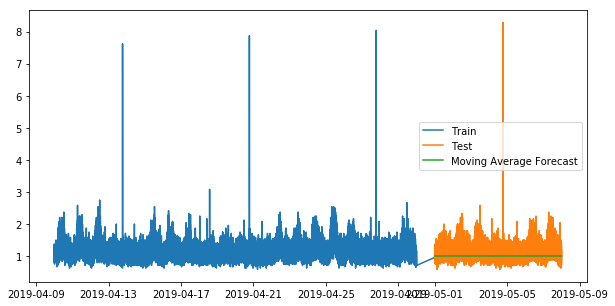

In [63]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['value'].rolling(15).mean().iloc[-1]
plt.figure(figsize=(10,5))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [64]:
rms = sqrt(mean_squared_error(test.value, y_hat_avg['moving_avg_forecast']))
print(rms)


0.32376575894581905


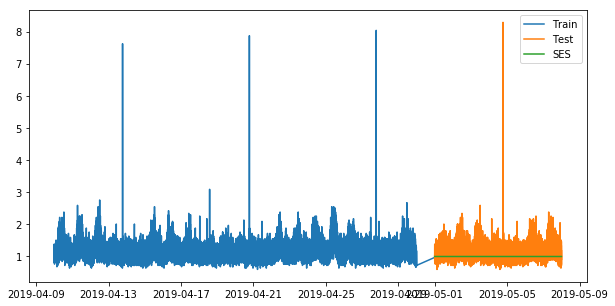

In [73]:

y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['value'])).fit(smoothing_level=0.1,optimized=True)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(10,5))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()


In [74]:
rms = sqrt(mean_squared_error(test.value, y_hat_avg['SES']))
print(rms)


0.3328010514458384


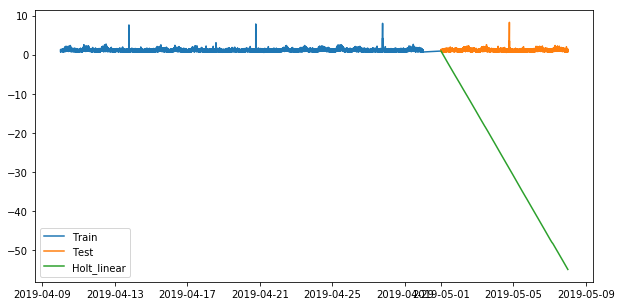

In [75]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['value'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(10,5))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()


In [77]:
rms = sqrt(mean_squared_error(test.value, y_hat_avg.Holt_linear))
print(rms)

32.451819618554474


In [98]:
sam2=frame12[frame12['device_ip']=='192.168.224.3']

In [99]:
sam2.metric_text.unique()

array(['Availability', 'CiscoMemoryUtilization', 'CiscoTemperature',
       'PacketLoss', 'RouterCPUUtilization', 'ResponseTime'], dtype=object)

In [100]:
sam2=sam2[sam1['metric_text']=='ResponseTime'][['time','metric_text','value']]
sam2.index=pd.to_datetime(sam2['time'])
sam2=sam2.drop(['time'],axis=1)

sam2.head()

,metric_text,value
time,,
2019-04-10 00:00:00,ResponseTime,45.0
2019-04-10 00:01:00,ResponseTime,37.0
2019-04-10 00:02:00,ResponseTime,35.0
2019-04-10 00:03:00,ResponseTime,35.0
2019-04-10 00:04:00,ResponseTime,41.0


In [101]:
sam2 = sam2.loc[sam2.index.duplicated(keep='first')]

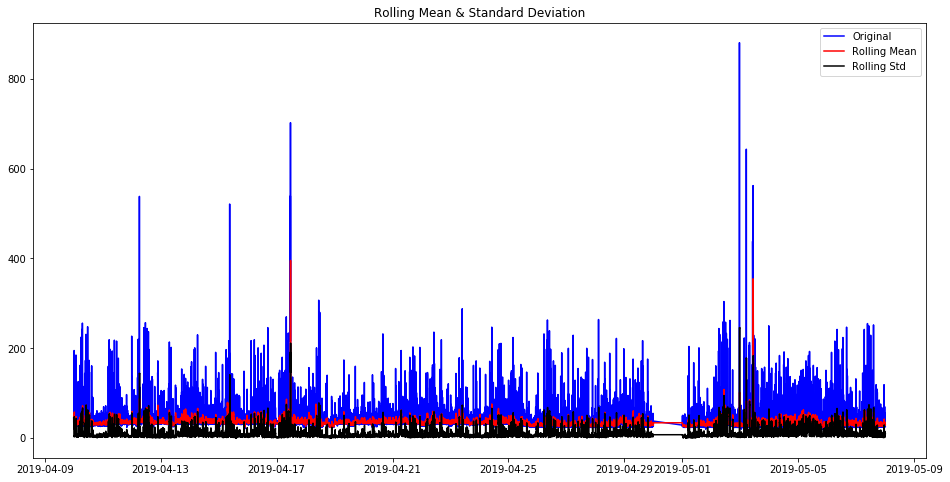

Results of Dickey-Fuller Test:
Test Statistic                   -23.784842
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    38372.000000
Critical Value (1%)               -3.430520
Critical Value (5%)               -2.861615
Critical Value (10%)              -2.566810
dtype: float64


In [102]:
test_stationarity(sam2['value'])

In [103]:
train=sam2[:'2019-05-01 00:00:00']
test=sam2['2019-05-01 00:00:00':]

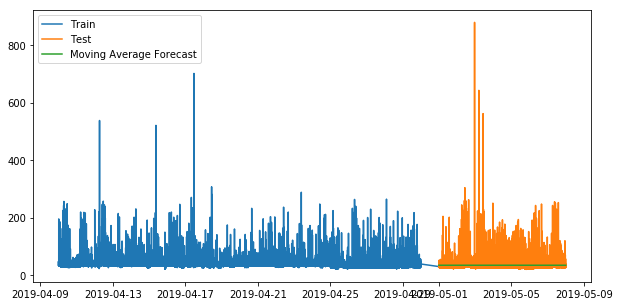

In [106]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['value'].rolling(15).mean().iloc[-1]
plt.figure(figsize=(10,5))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [107]:
rms = sqrt(mean_squared_error(test.value, y_hat_avg['moving_avg_forecast']))
print(rms)


29.275574662385974


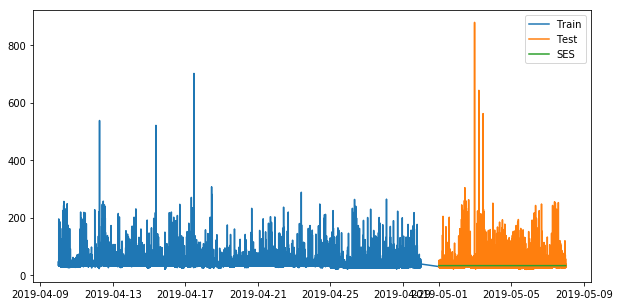

In [112]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['value'])).fit(smoothing_level=0.5,optimized=True)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(10,5))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()


In [113]:
rms = sqrt(mean_squared_error(test.value, y_hat_avg['SES']))
print(rms)

29.37995313573869


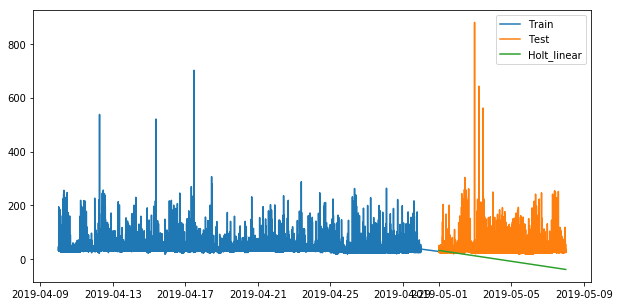

In [114]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['value'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(10,5))
plt.plot(train['value'], label='Train')
plt.plot(test['value'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()


In [115]:
rms = sqrt(mean_squared_error(test.value, y_hat_avg.Holt_linear))
print(rms)

51.80400903226765


In [116]:
sam3=frame12[frame12['device_ip']=='10.254.231.7']

In [117]:
sam3.metric_text.unique()

array(['Availability'], dtype=object)